# Latent Dirichlet Analysis (LDA) for Topic Modeling
In this notebook LDA is used for topic modeling, leveraging LDA implementations from different libraries and experimenting with different preprocessing steps and corpus representations.

Variations include:
- POS filtering
- dictionary extremes filtering
- BoW, TF-IDF, Bigram corpuses

## Data Preprocessing

### Import Data
Data collection was performed by using PRAW and PSAW to scrape comments from historical reddit posts from a specific subreddit.

In [2]:
import pandas as pd
load_subreddit = "hololive"
load_num_posts = 20000
load_num_days = 180
comments_df = pd.read_csv(f'./data/{load_subreddit}_comments_{load_num_posts}_{load_num_days}.csv', delimiter=';', header=0)

In [3]:
comments_df.shape

(198277, 6)

In [101]:
comments_df.head(3)

,id,score,body,parent_id,link_id,created_utc
0,ggfbfj6,3,when you watch hoshikawa 3D debut but still sa...,t3_kgj7s6,t3_kgj7s6,1.608425e+09
1,ggfshy6,1,Matsurimp,t3_kgj7s6,t3_kgj7s6,1.608436e+09
2,ggf49zm,104,A dog of determination,t3_kgj4yb,t3_kgj4yb,1.608422e+09


### Data Cleaning

In [4]:
import re
import nltk
from nltk import word_tokenize

In [5]:
def clean_comment(comment, stop_words, lemmatizer):
    """
    Description:
        We clean the comment by removing comment quotes, URLS, punctuation, 
        and discarding tokens that are not alphanumeric. We don't include words which are
        stopwords in english
        
    Input:
        comment: a raw comment text string
        stop_words: a set of stop words to be eliminated
        lemmatizer: a function with a method to lemmatize text
    
    Output:
        clean_comment: an array of token representing the clean comment ready to be used in a corpus 
    """
    
    if isinstance(comment, str):
        # remove comment quotes
        comment = re.sub(r'^>(.*?)\n$', '', comment, flags=re.M)

        # replace URLs with token
        comment = re.sub(r'https*://\S*', '', comment)

        # remove punctuation
        comment = re.sub(r'[.,!?;]+', '', comment)
    else:
        return []
    
    comment_tokens = nltk.word_tokenize(comment)
    clean_comment = [ch.lower() for ch in comment_tokens 
                     if ch.isalpha() and
                     ch.lower() not in stop_words 
                     and len(ch) > 1
                    ]
    clean_comment = [lemmatizer.lemmatize(word) for word in clean_comment]
    return clean_comment

In [6]:
# Define lemmatizer and stop words
from nltk.stem.wordnet import WordNetLemmatizer
wnl = WordNetLemmatizer()

from gensim.parsing.preprocessing import STOPWORDS
en_stop = STOPWORDS.union(set(['like', 'savevideo']))

In [7]:
post_to_comments_dict = {}
all_comments = []
post_ids = comments_df['link_id'].unique()

for post_id in post_ids:
    comments = []
    # clean comments
    comments_raw = comments_df[comments_df['link_id'] == post_id]['body']
    for comment in comments_raw:
        comments.extend(clean_comment(comment, en_stop, wnl))
    all_comments.extend(comments)
    post_to_comments_dict[post_id] = comments
    
len(all_comments)

1446400

## Data Exploration

In [8]:
len(post_to_comments_dict.keys())

12431

We can see that we are using 12431 posts and 198277 comments for topic modeling of the subreddit


Common Words:  [('stream', 11548), ('time', 9307), ('know', 8624), ('think', 8193), ('people', 8127), ('hololive', 7820), ('good', 7279), ('thing', 6414), ('got', 5714), ('want', 5425)]


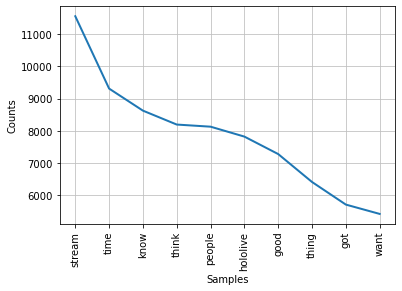

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [12]:
from nltk.probability import FreqDist
fdist = FreqDist(all_comments)
common_words = fdist.most_common(10)
print("\nCommon Words: ", common_words)
fdist.plot(10)

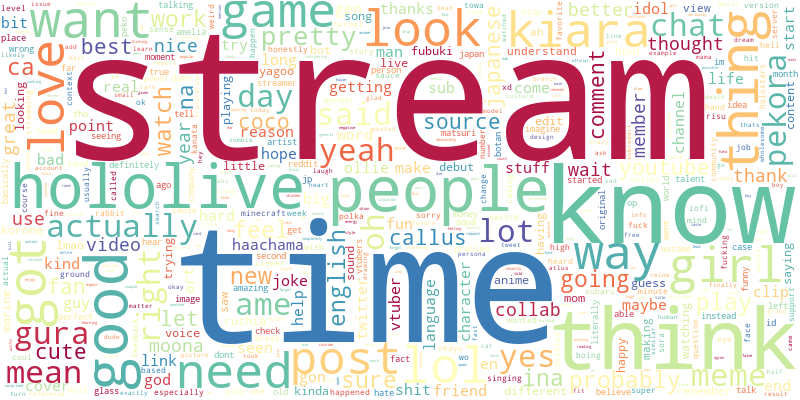

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", width=800, height=400, colormap="Spectral", max_words=500)
wordcloud.generate_from_frequencies(fdist)
wordcloud.to_image()

# Model 0 - sklearn LDA with BoW

In [28]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
#Convert each array of word tokens in post_to_comments_list into a string
post_to_comments_list_str = []
for arr in post_to_comments_list:
    post_to_comments_list_str.append(' '.join(arr))

# Initialise the count vectorizer
count_vectorizer = CountVectorizer()

In [29]:
# Fit and transform the processed comments
count_data = count_vectorizer.fit_transform(post_to_comments_list_str)

In [90]:
count_data[:4].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [30]:
# Helper function
def print_sklearn_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [34]:
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda_model_0 = LDA(n_components=number_topics, n_jobs=-1)
lda_model_0.fit(count_data)

LatentDirichletAllocation(n_jobs=-1)

In [72]:
def plot_top_sk_words(model, count_vectorizer, num_topics, title, n_top_words=10):
    assert num_topics % 2 == 0, f'num_topics={num_topics} not divisible nicely by 2'
    assert num_topics // 2 < 7, f'num_topics={num_topics} is too high and will not display well'
    
    plot_cols = num_topics // 2
    
    fig, axes = plt.subplots(2, plot_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    words = count_vectorizer.get_feature_names()
    for topic_id, topic in enumerate(model.components_):
        top_words_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [words[i] for i in top_words_ind]
        weights = topic[top_words_ind]
        
        ax = axes[topic_id]
        ax.barh(top_words, weights, height=0.7)
        ax.set_title(f'Topic {topic_id +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

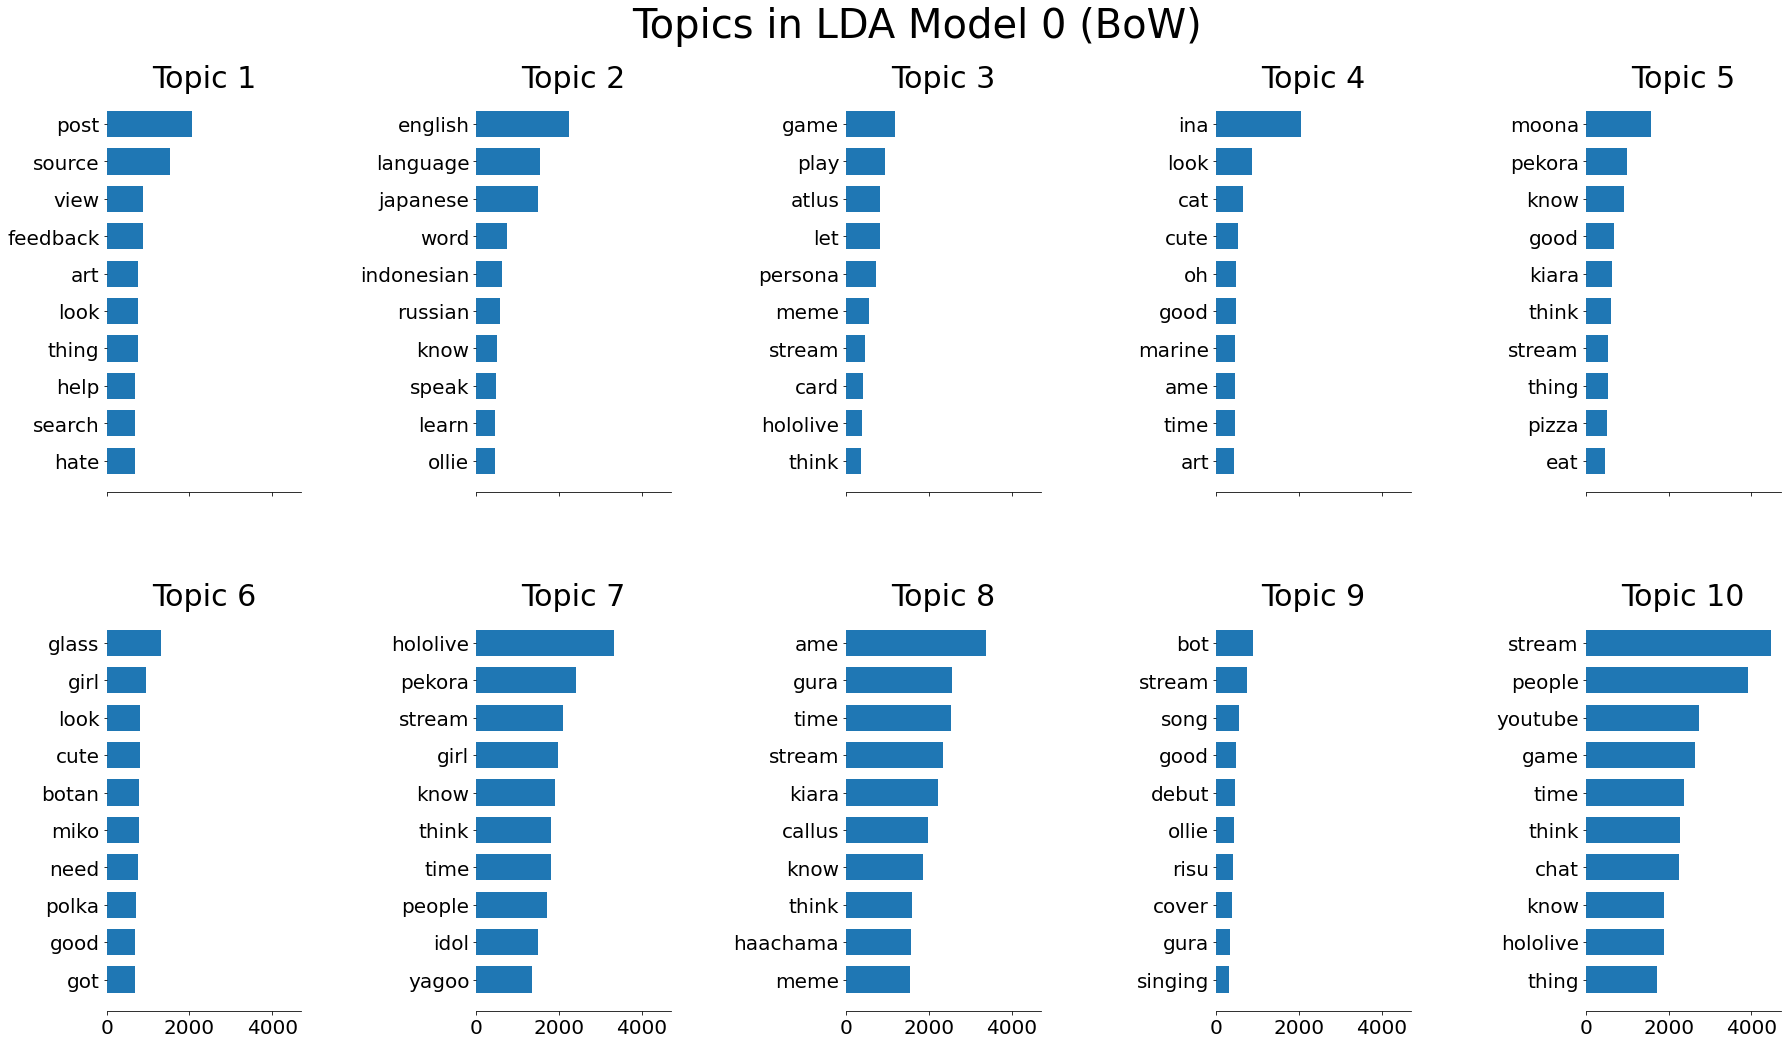

In [82]:
plot_top_sk_words(lda_model_0, count_vectorizer, 10, 'Topics in LDA Model 0 (BoW)')

In [76]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

In [95]:
import numpy as np

In [100]:
coherence_model_sk = metric_coherence_gensim(measure='c_v', 
                        topic_word_distrib=lda_model_0.components_, 
                        vocab=np.array([x for x in count_vectorizer.vocabulary_.keys()]), 
                        dtm=count_data,
                        texts=post_to_comments_list,
                        return_coh_model=True)
coherence_sk = coherence_model_sk.get_coherence()
coherence_sk

0.6961460124468651

This seems pretty high for a coherence score when the typical score has been around 0.4 for the rest of the models... I may have used this metric coherence method incorrectly

# Model 1 - Gensim LDA with BoW

Inspiration for Gensim with BoW: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

## Model Training

### Create Id to Word Dictionary

In [14]:
import gensim

In [15]:
# Create a list of post comment lists
post_to_comments_list = list(post_to_comments_dict.values())

In [16]:
dictionary = gensim.corpora.Dictionary(post_to_comments_list)

In [17]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 debut
1 hoshikawa
2 lol
3 matsurihaachama
4 matsurimp
5 saw
6 watch
7 yagoo
8 accidental
9 ah
10 ancient


### Create Bag of Words Corpus

Let's filter out terms which appear in less than 10 documents, and terms which appear in more than 50% of documents, as well as keeping only the first 100,000 most frequent tokens

In [18]:
dictionary.filter_extremes(no_below=15, no_above=0.4, keep_n=100000)

In [19]:
bow_corpus = [dictionary.doc2bow(post) for post in post_to_comments_list]

### Train Model

In [20]:
from gensim.models import LdaMulticore

In [36]:
lda_model_1 = LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=10, chunksize=100, random_state=100, workers=7)

## Assess Model Results

In [39]:
for idx, topic in lda_model_1.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.036*"glass" + 0.021*"source" + 0.018*"search" + 0.017*"perfect" + 0.017*"cat" + 0.017*"feedback" + 0.017*"view" + 0.017*"post" + 0.016*"cute" + 0.016*"thing"
Topic: 1 
Words: 0.018*"kiara" + 0.014*"ame" + 0.013*"callus" + 0.008*"time" + 0.007*"oh" + 0.006*"yagoo" + 0.006*"know" + 0.006*"meme" + 0.006*"got" + 0.006*"amelia"
Topic: 2 
Words: 0.035*"gura" + 0.014*"ame" + 0.011*"coco" + 0.010*"stream" + 0.008*"time" + 0.008*"lol" + 0.007*"shark" + 0.006*"kanata" + 0.005*"sleep" + 0.005*"good"
Topic: 3 
Words: 0.056*"pekora" + 0.031*"moona" + 0.017*"peko" + 0.011*"rabbit" + 0.009*"mom" + 0.009*"korone" + 0.009*"botan" + 0.008*"know" + 0.007*"stream" + 0.006*"love"
Topic: 4 
Words: 0.025*"stream" + 0.017*"hololive" + 0.010*"collab" + 0.010*"time" + 0.009*"gen" + 0.008*"member" + 0.007*"good" + 0.007*"girl" + 0.007*"song" + 0.007*"voice"
Topic: 5 
Words: 0.017*"game" + 0.010*"play" + 0.010*"hololive" + 0.010*"stream" + 0.008*"think" + 0.008*"people" + 0.008*"time" + 0.006*"

In [23]:
import matplotlib.pyplot as plt

In [24]:
def plot_top_words(model, dictionary, num_topics, title, n_top_words=10):
    assert num_topics % 2 == 0, f'num_topics={num_topics} not divisible nicely by 2'
    assert num_topics // 2 < 7, f'num_topics={num_topics} is too high and will not display well'
    
    plot_cols = num_topics // 2
    
    fig, axes = plt.subplots(2, plot_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_id in range(num_topics):
        topic_features = list()
        weights = list()
        
        for word_id, freq in model.get_topic_terms(topic_id, n_top_words):
            topic_features.append(dictionary[word_id])
            weights.append(freq)
        
        ax = axes[topic_id]
        ax.barh(topic_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_id +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

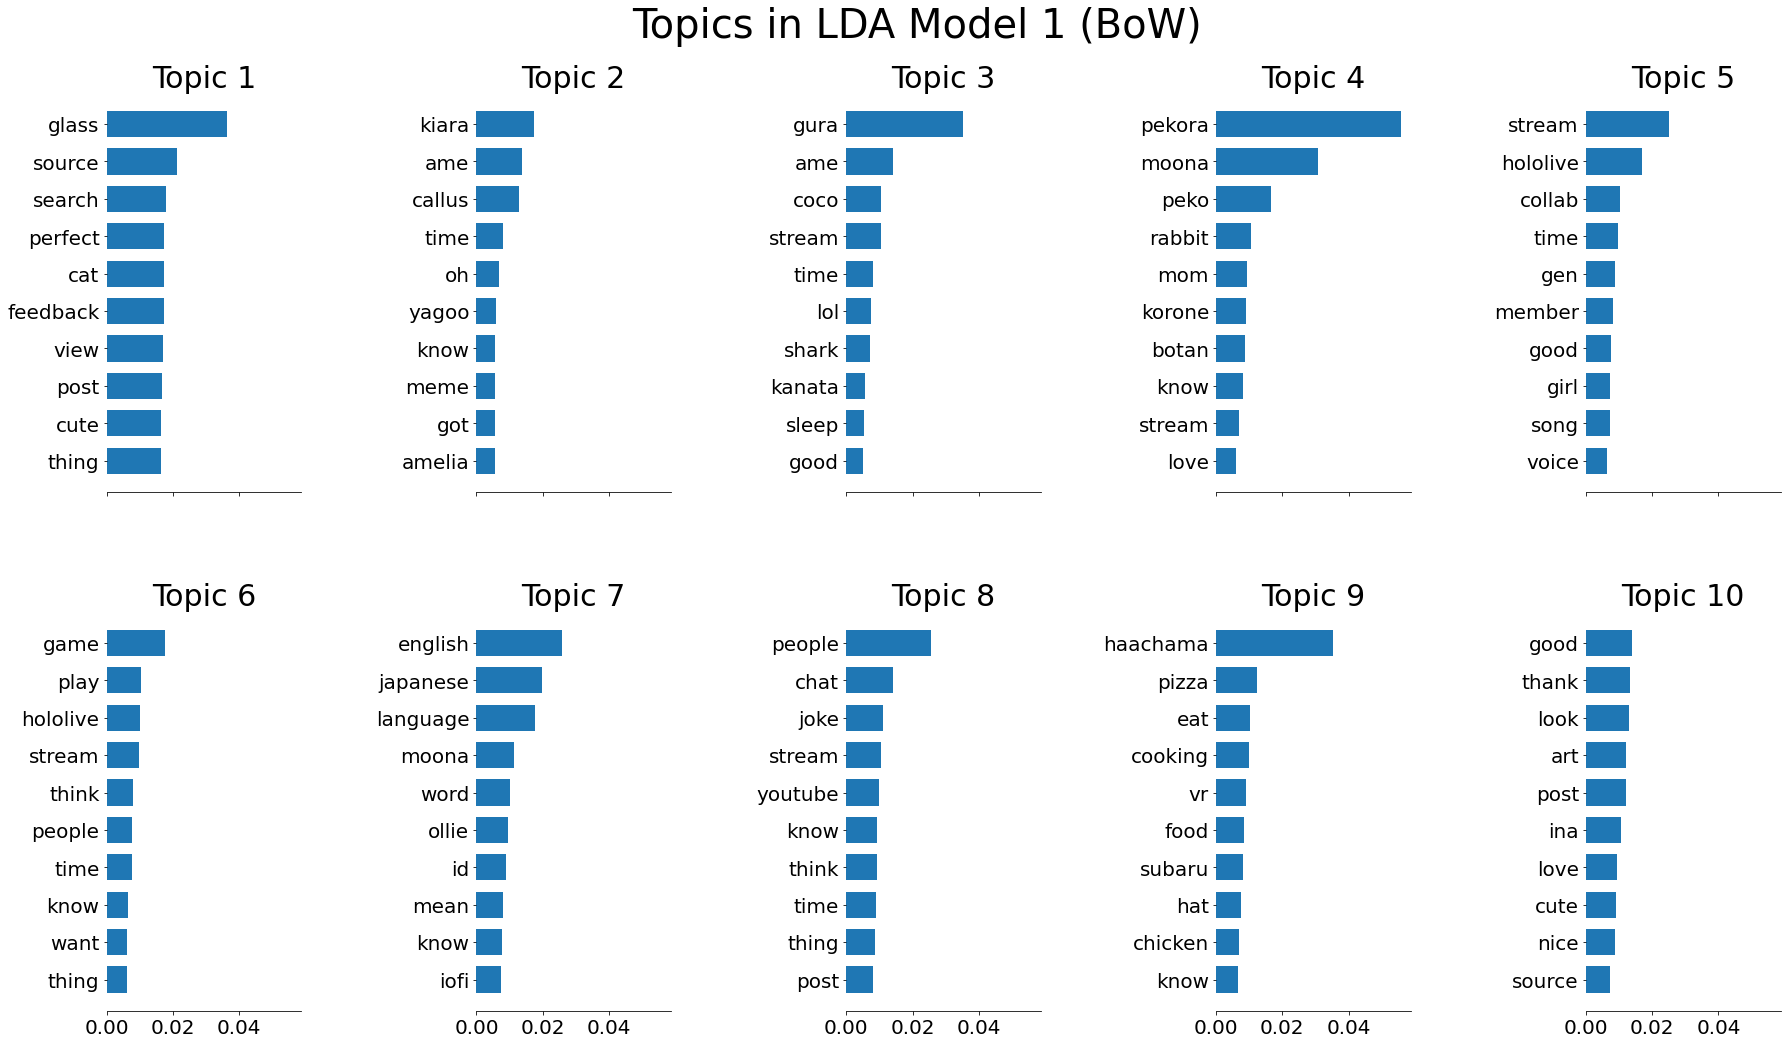

In [40]:
plot_top_words(lda_model_1, dictionary, 10, 'Topics in LDA Model 1 (BoW)')

In [41]:
for topic_id in range(10):
    print(f'\nTopic: {topic_id}')
    for word_id, freq in lda_model_1.get_topic_terms(topic_id):
        print(f'{dictionary[word_id]} - {freq}')


Topic: 0
glass - 0.036498721688985825
source - 0.0212941225618124
search - 0.017910966649651527
perfect - 0.017392072826623917
cat - 0.01729252189397812
feedback - 0.01722024381160736
view - 0.017131688073277473
post - 0.016878969967365265
cute - 0.016356335952878
thing - 0.016288677230477333

Topic: 1
kiara - 0.017516521736979485
ame - 0.01373298279941082
callus - 0.012712552212178707
time - 0.00798543356359005
oh - 0.006916853133589029
yagoo - 0.0059143234975636005
know - 0.00575304077938199
meme - 0.005702493712306023
got - 0.0056751263327896595
amelia - 0.005564570426940918

Topic: 2
gura - 0.035222750157117844
ame - 0.014147375710308552
coco - 0.010507399216294289
stream - 0.010474957525730133
time - 0.008165169507265091
lol - 0.00755537673830986
shark - 0.007234389428049326
kanata - 0.005697429180145264
sleep - 0.005321546923369169
good - 0.005202231928706169

Topic: 3
pekora - 0.05595819279551506
moona - 0.030881278216838837
peko - 0.016624815762043
rabbit - 0.01059446111321449

### Evaluate Results from Coherence

In [42]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_1, texts=post_to_comments_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3783287460809634


For the base model we get a coherence score of 0.37832, looking at the topics created, some of these make sense, topic 4 we can see is made up of words such as pekora, peko, moona, rabbit, mom - which makes sense as pekora and peko refer to the same person who is a rabbit, frequently featuring moona in their streams, and had a very popular stream with their mom. We can see that Topic 7 and Topic 9 are also of higher quality, seemingly creating meaningful groupings. However, we can also see some topics are fairly generic, Topic 1, 5, 6, 8, as well as some overlap with words frequently occuring in multiple topics: source, good, stream, thing.

# Model 2 - LDA with TF-IDF
Inspiration: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [43]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

### Train Model

In [44]:
lda_model_2 = LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=10, chunksize=100, random_state=100, workers=7)

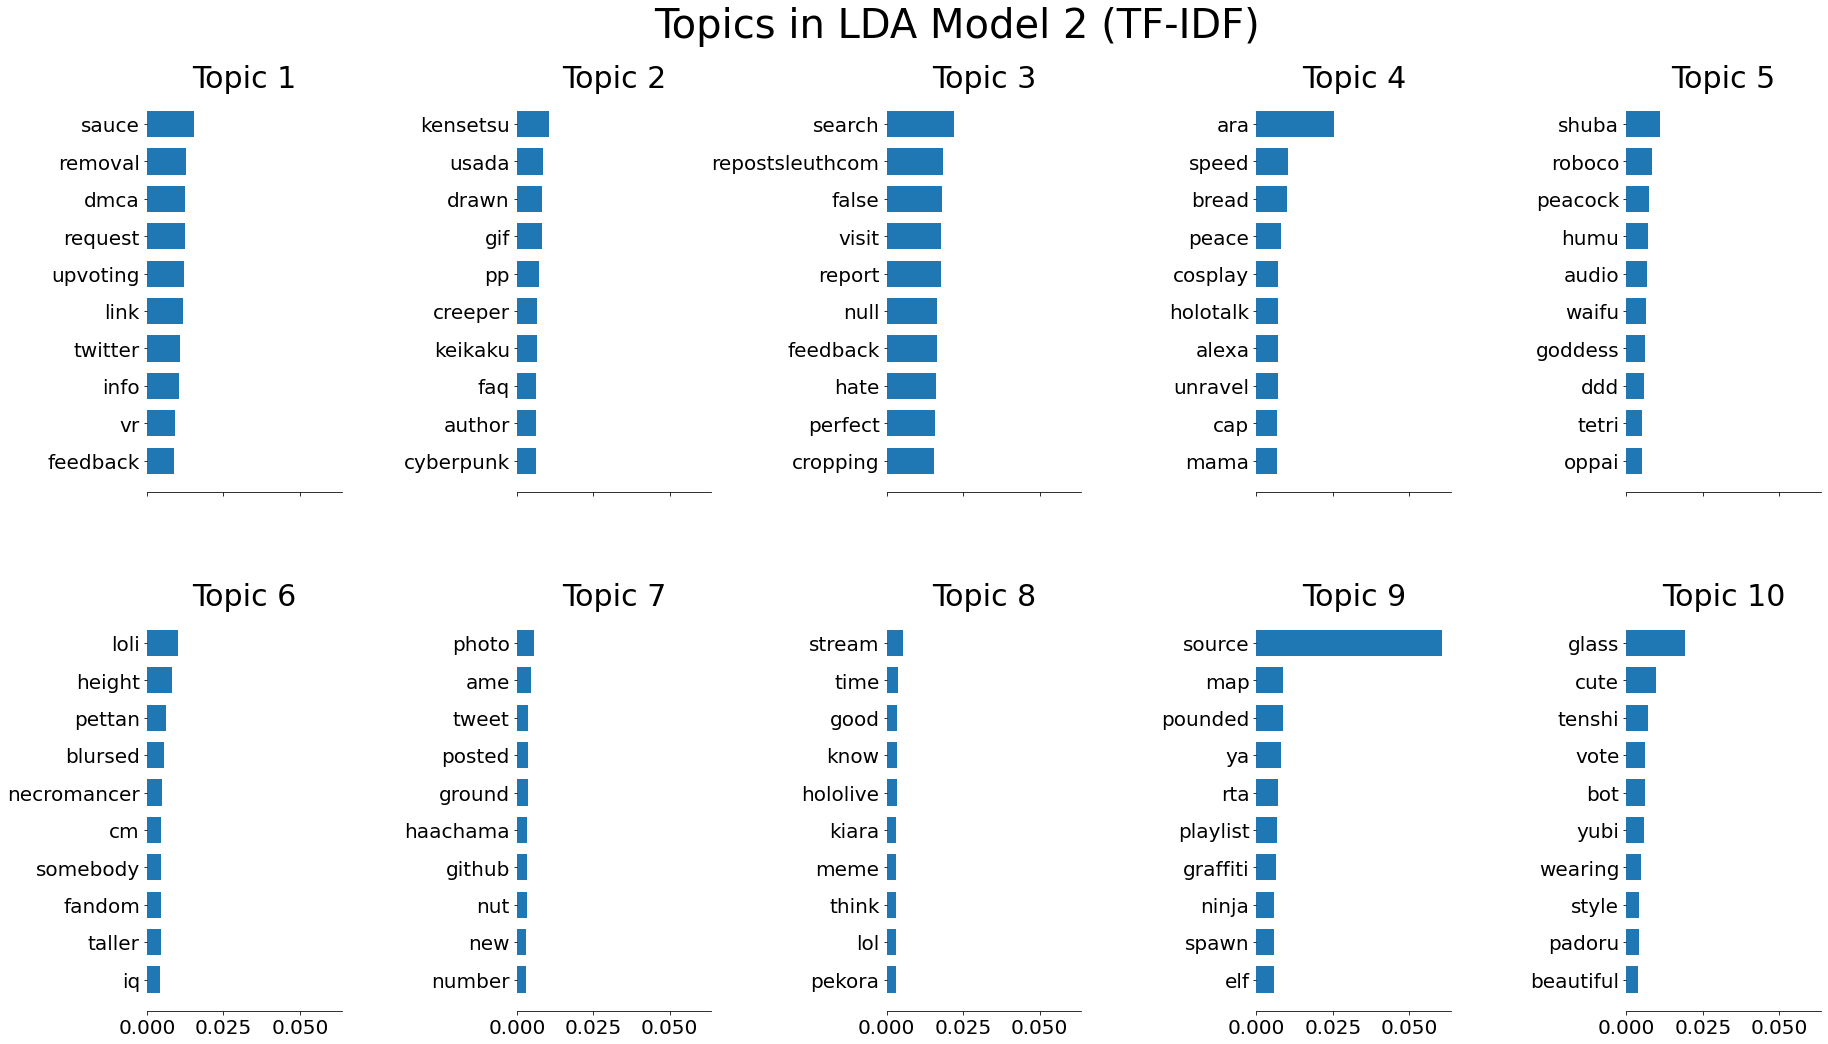

In [45]:
plot_top_words(lda_model_2, dictionary, 10, 'Topics in LDA Model 2 (TF-IDF)')

In [46]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_2, texts=post_to_comments_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4345562773589416


For the base model we get a coherence score of 0.43455, however doing a qualitative analysis of the topics created, the groupings seem less meaningful than the topics created in the previous model, however the TF-IDF has surfaced some of the unique words used in the comments and has created topics with much less overlap.

# Model 3 & 4 - LDA with Bigrams
Inspiration: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

For models 3 & 4, I did not filter out extremes in the dictionary (frequent or infrequent words)

In [47]:
# Build the bigram model
bigram = gensim.models.Phrases(post_to_comments_list, min_count=5, threshold=100) # higher threshold fewer phrases.

In [48]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [49]:
# def functions for bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [50]:
import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, postag_filter=True, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        if postag_filter:
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append([token.lemma_ for token in doc])
    return texts_out

In [51]:
# Form Bigrams
data_words_bigrams = make_bigrams(post_to_comments_list)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [52]:
print(data_lemmatized[:2])

[['see'], ['procced', 'scene', 'pretty', 'funny', 'game', 'fun', 'run', 'see', 'bloodthirsty', 'vike', 'end', 'have', 'accidental', 'sex', 'worry', 'fall', 'game', 'moment', 'end', 'require', 'kill', 'order', 'ancient', 'member', 'glad', 'man', 'want', 'play', 'skyrim', 'hour', 'ecin', 'hope', 'finally', 'play', 'doom_eternal', 'dog', 'focus_commitment', 'sheer', 'fuck', 'traumatic', 'point', 'live', 'go', 'shock', 'reckon', 'engage', 'watch', 'stream', 'live', 'solid', 'minute', 'laughing', 'good', 'event', 'hit', 'hard', 'rig', 'know', 'feel', 'lifeless', 'avatar', 'hover', 'cement', 'happen', 'love']]


In [53]:
import gensim.corpora as corpora
# Create Dictionary
id2word_3 = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts_3 = data_lemmatized
# Term Document Frequency
corpus_3 = [id2word_3.doc2bow(text) for text in texts_3]

In [54]:
[id2word_3[word_id] for word_id, freq in corpus_3[2]]

['stream',
 'absolutely',
 'actually',
 'alien',
 'apologize',
 'baby',
 'certain',
 'clip',
 'fix',
 'forget',
 'original',
 'sauce',
 'source',
 'thank',
 'yeete']

### Train Model

In [55]:
lda_model_3 = gensim.models.LdaMulticore(corpus=corpus_3,
                                           id2word=id2word_3,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           workers=7)

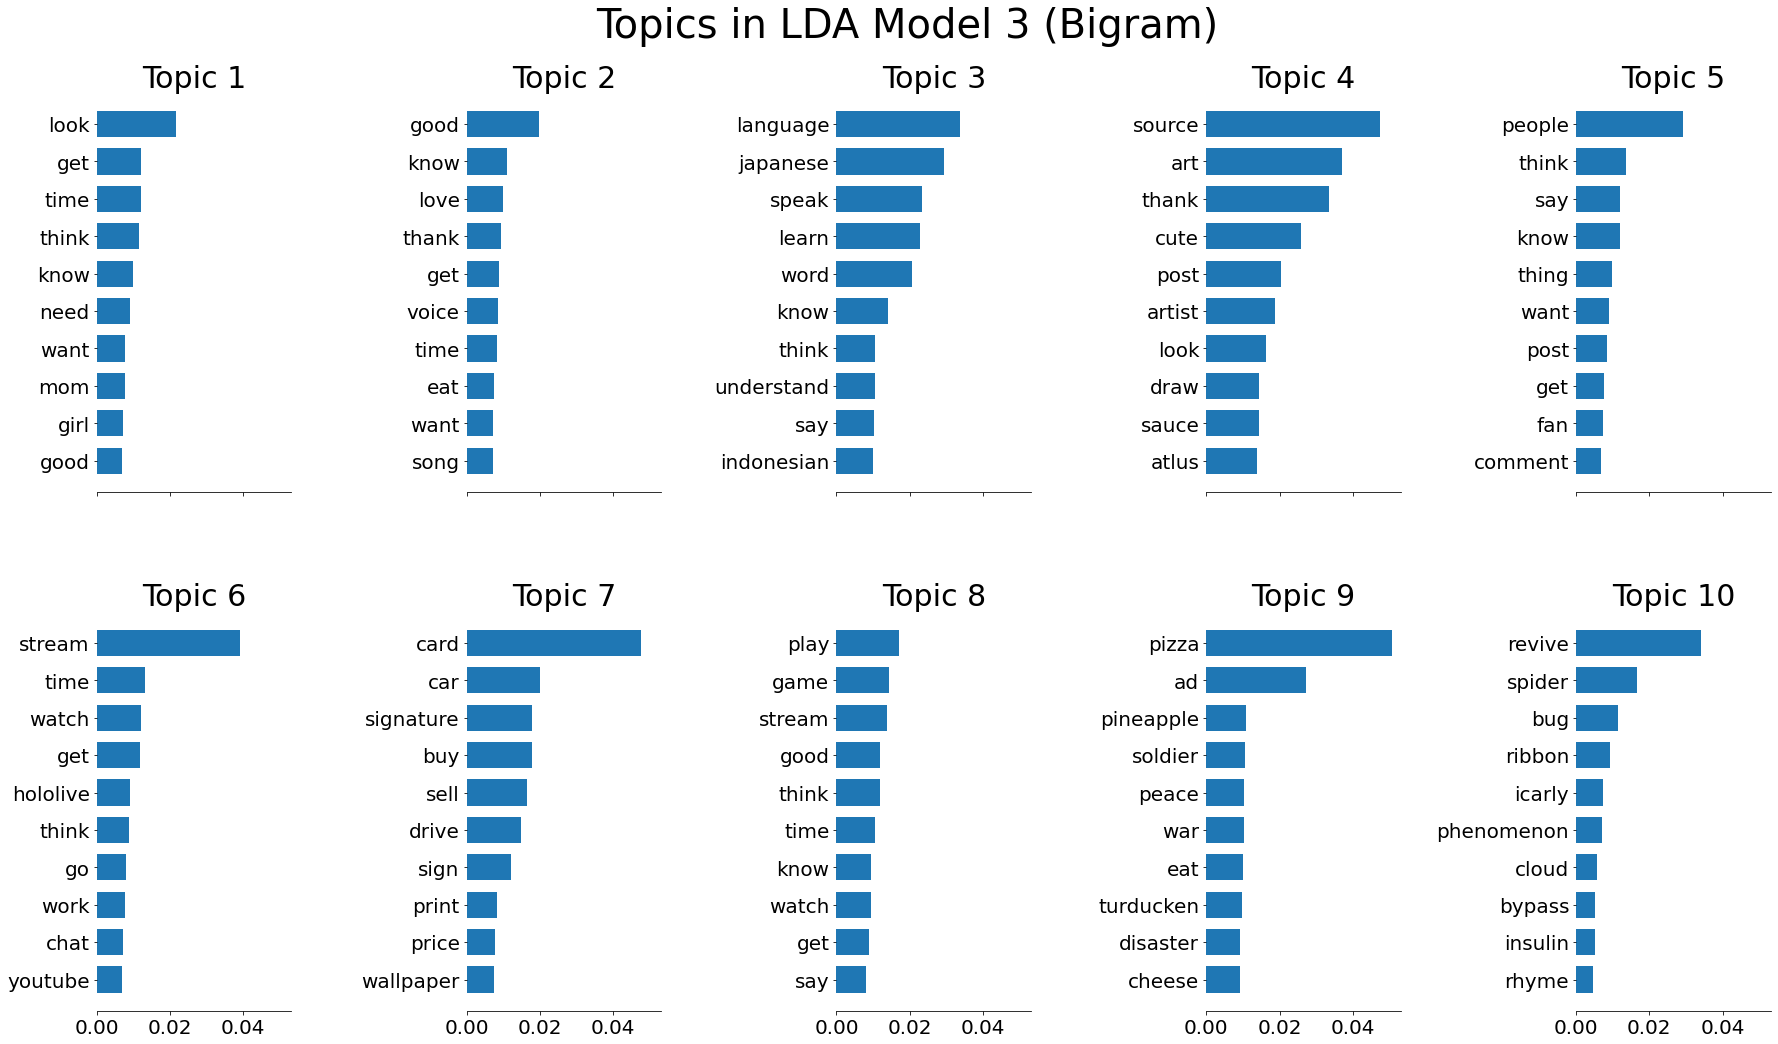

In [62]:
plot_top_words(lda_model_3, id2word_3, 10, 'Topics in LDA Model 3 (Bigram)')

In [57]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_3, texts=data_lemmatized, dictionary=id2word_3, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.37759363864649587


The inital N-gram model with POS tag filtering based on `['NOUN', 'ADJ', 'VERB', 'ADV']` resulted in the lowest coherence score so far: 0.37759. We can also see from the topics that a lot of the names of vtubers have been lost, most likely due to this POS tag filtering. Some of these topics make sense when looking at how the keywords are related to each other, but overall its unclear if the topics are meaningful in relation to the subreddit.

## Train Model without POS filtering

In [58]:
data_lemmatized = lemmatization(data_words_bigrams, postag_filter=False)

# Create Dictionary
id2word_4 = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts_4 = data_lemmatized
# Term Document Frequency
corpus_4 = [id2word_4.doc2bow(text) for text in texts_4]

In [59]:
lda_model_4 = gensim.models.LdaMulticore(corpus=corpus_4,
                                           id2word=id2word_4,
                                           num_topics=10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True,
                                           workers=7)

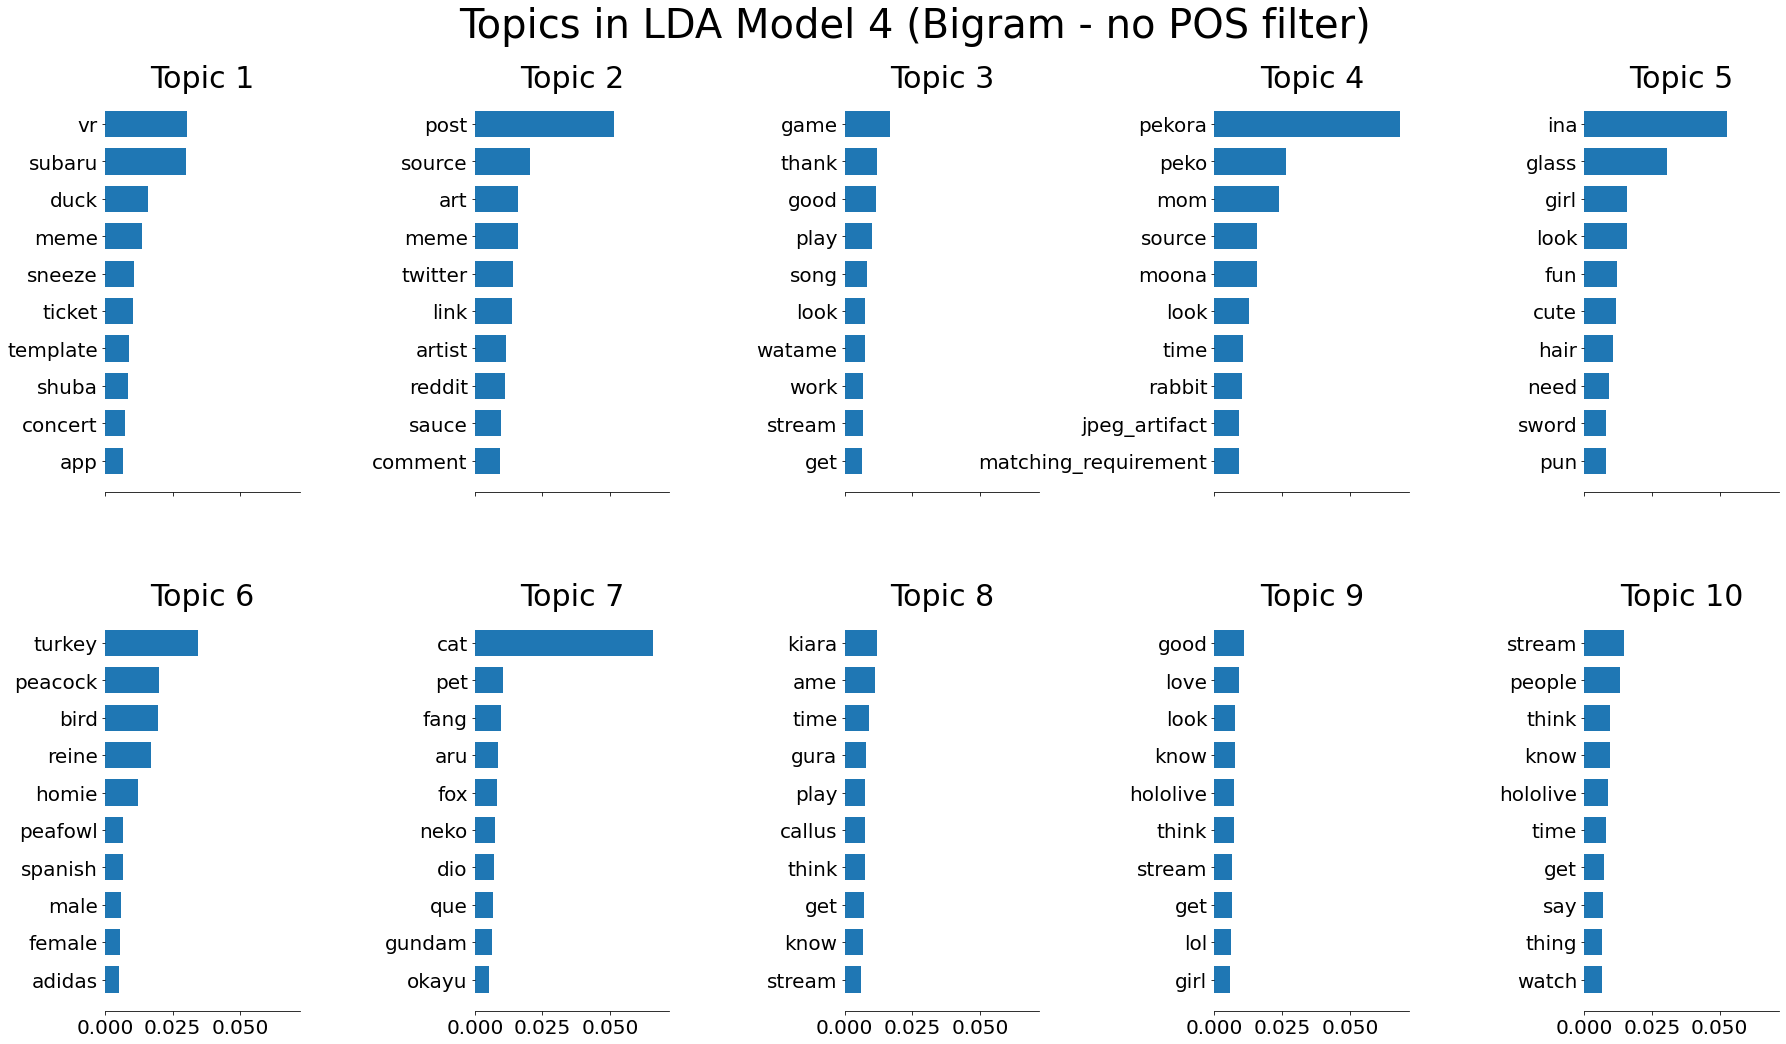

In [63]:
plot_top_words(lda_model_4, id2word_4, 10, 'Topics in LDA Model 4 (Bigram - no POS filter)')

In [61]:
coherence_model_lda = CoherenceModel(model=lda_model_4, texts=data_lemmatized, dictionary=id2word_4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3861404633309475


We get a more improved Coherence score of 0.38614 for the bigram representation, however, looking at the topics its difficult to determine how much of an improvement this is. We can also see that we have captured some weird bigrams such as jpeg_artifact, and matching_requirement in Topic 4.

# Model 5 - LDA Mallet
Inspiration: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [64]:
import os
mallet_home = os.path.join('C:', os.path.sep, 'new_mallet', 'mallet-2.0.8')
print(mallet_home)
os.environ['MALLET_HOME'] = mallet_home
os.getenv('MALLET_HOME')

C:\new_mallet\mallet-2.0.8


'C:\\new_mallet\\mallet-2.0.8'

In [65]:
mallet_path = os.path.join(mallet_home, 'bin', 'mallet')
print(mallet_path)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_4, num_topics=10, id2word=id2word_4, workers=7)

C:\new_mallet\mallet-2.0.8\bin\mallet


In [66]:
def plot_top_words_mallet(model, num_topics, title, n_top_words=10):
    assert num_topics % 2 == 0, f'num_topics={num_topics} not divisible nicely by 2'
    assert num_topics // 2 < 7, f'num_topics={num_topics} is too high and will not display well'
    
    plot_cols = num_topics // 2
    
    fig, axes = plt.subplots(2, plot_cols, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    topics_list = model.show_topics(formatted=False)
    
    for topic_id, top_words in topics_list:
        topic_features = list()
        weights = list()
        
        for word, freq in top_words:
            topic_features.append(word)
            weights.append(freq)
        
        ax = axes[topic_id]
        ax.barh(topic_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_id +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)  

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

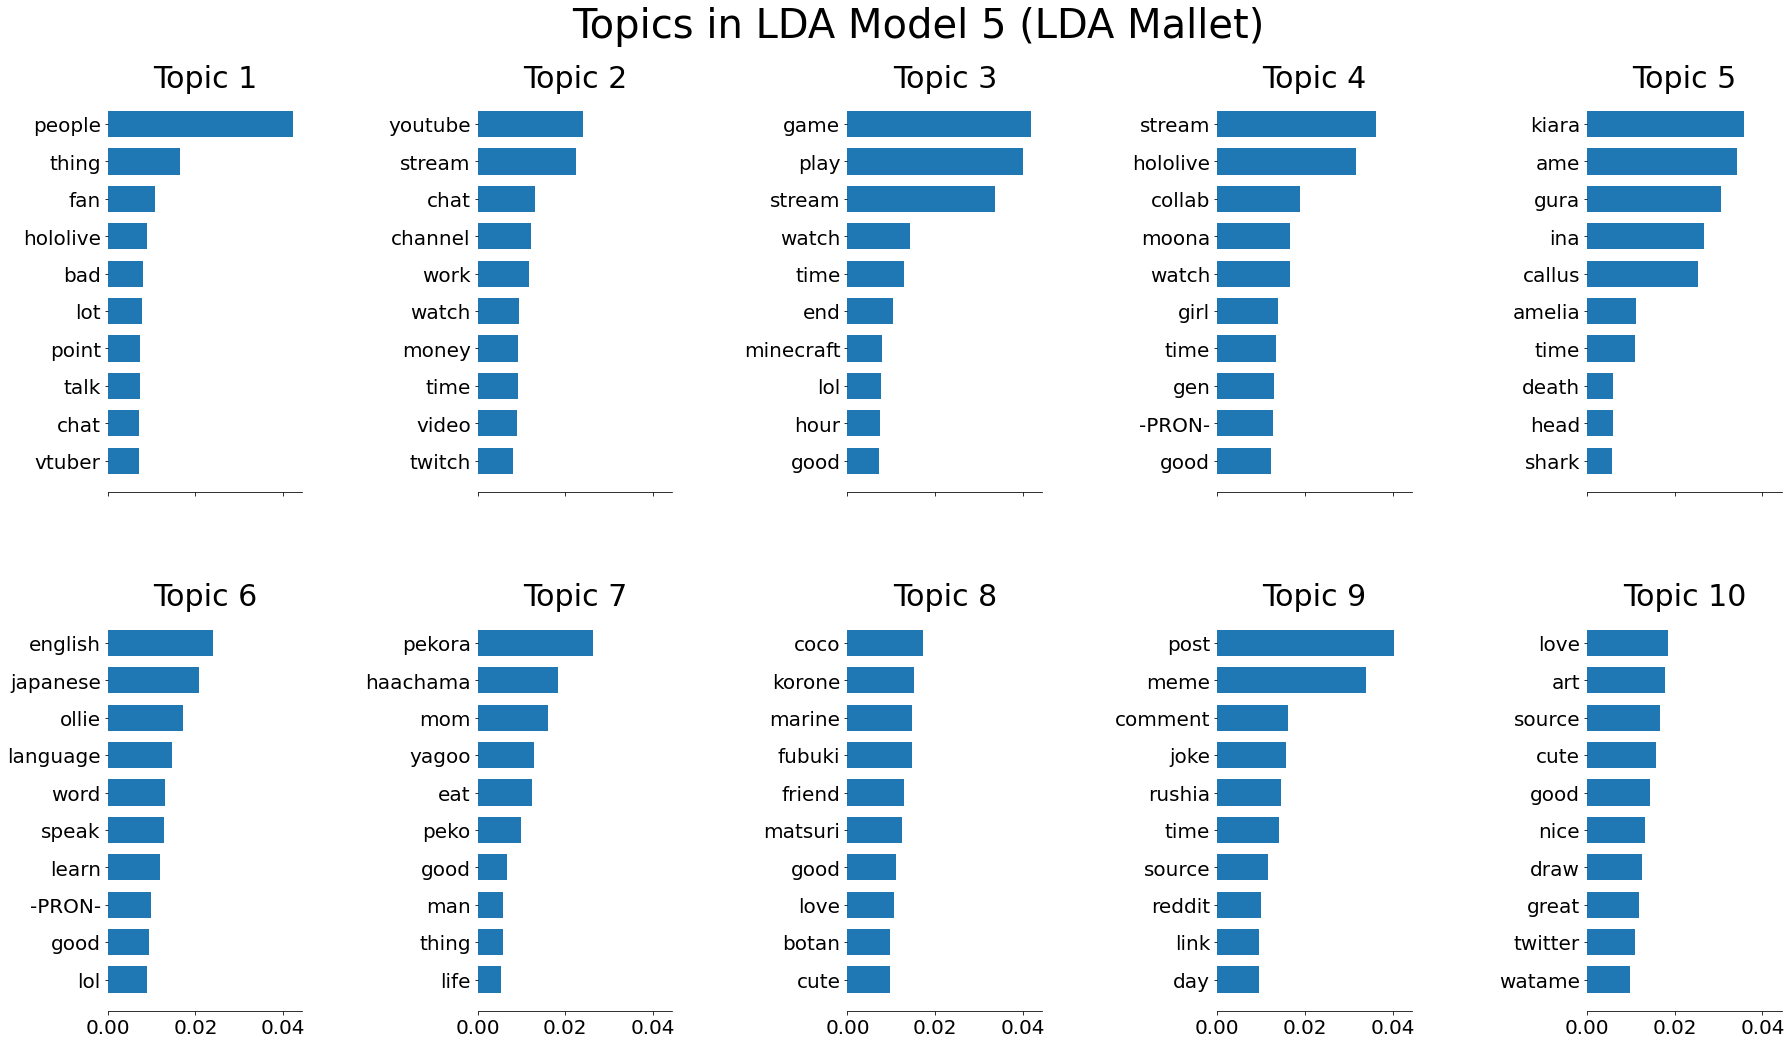

In [67]:
plot_top_words_mallet(ldamallet, 10, 'Topics in LDA Model 5 (LDA Mallet)')

In [33]:
coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word_4, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.39308153157197756


The coherence score is 0.39308 for the LDA Mallet model, examining some of the words appearing in each of the topics we see that there is a weird token called -PRON- appearing in topics 7 and 10

# Comparing Topic Distributions
We use the gensim diff method to examine the Kullback Liebler (KL) divergence between the topic distributions of each model

In [140]:
mdiff, annotation = lda_model_1.diff(lda_model_2)

In [113]:
# topic 1 from lda_model_1, for each topic from lda_model_2 show words which intersect, and the words from the symmetric difference
annotation[0]  

array([list([['view', 'twitter', 'source', 'post', 'feedback'], ['deepl', 'kind', 'officially', 'referencing', 'putting', 'japanglish', 'friend', 'cropping', 'meet', 'move']]),
       list([[], ['ep', 'kind', 'officially', 'putting', 'friend', 'advance', 'cropping', 'meet', 'mb', 'rider']]),
       list([['cute', 'view', 'twitter', 'perfect', 'result', 'searched', 'false', 'feedback', 'time', 'artifact'], ['smiling', 'kind', 'officially', 'putting', 'friend', 'huke', 'mio', 'marine', 'mashup', 'mid']]),
       list([[], ['interview', 'taiwan', 'kind', 'tokyo', 'officially', 'putting', 'friend', 'phase', 'cropping', 'meet']]),
       list([[], ['husband', 'kind', 'officially', 'gawr', 'putting', 'friend', 'wonderful', 'dat', 'cropping', 'guitar']]),
       list([[], ['birb', 'identity', 'min', 'silence', 'kind', 'officially', 'sephiroth', 'putting', 'max', 'friend']]),
       list([['beautiful', 'style', 'source'], ['boomer', 'demon', 'obviously', 'kind', 'noel', 'officially', 'putting'

In [116]:
# intersecting words from topic 1 and 1 from the lda_models 1 and 2
annotation[0][0][0]

['view', 'twitter', 'source', 'post', 'feedback']

In [112]:
labels = [f'Topic {i+1}' for i in range(10)]
labels

['Topic 1',
 'Topic 2',
 'Topic 3',
 'Topic 4',
 'Topic 5',
 'Topic 6',
 'Topic 7',
 'Topic 8',
 'Topic 9',
 'Topic 10']

In [117]:
# KL diveregence matrix between each of the topics
mdiff

array([[0.8109114 , 0.82725378, 0.49069099, 0.92700593, 0.94597062,
        0.93159814, 1.        , 0.79066691, 0.76923505, 0.70126061],
       [0.52953408, 0.4669155 , 0.64829797, 0.54735998, 0.58017952,
        0.58437543, 0.46619057, 0.26218259, 0.43111894, 0.63740206],
       [0.58257585, 0.53563887, 0.69628028, 0.61256727, 0.6462059 ,
        0.62949997, 0.53815019, 0.36230624, 0.49237447, 0.70300797],
       [0.61322779, 0.59697856, 0.7684233 , 0.64106663, 0.71517676,
        0.70817989, 0.65906538, 0.33935753, 0.55663175, 0.7745131 ],
       [0.59726419, 0.56258103, 0.74646606, 0.6458712 , 0.66720015,
        0.68259469, 0.67125031, 0.23772252, 0.52305225, 0.70954846],
       [0.51645458, 0.4613603 , 0.65751187, 0.545096  , 0.57474607,
        0.56898463, 0.53844015, 0.24977215, 0.42074714, 0.63484996],
       [0.64997528, 0.594928  , 0.78793152, 0.672315  , 0.70786598,
        0.71329722, 0.65070632, 0.32910136, 0.55188235, 0.76753833],
       [0.5920305 , 0.5475935 , 0.7169592

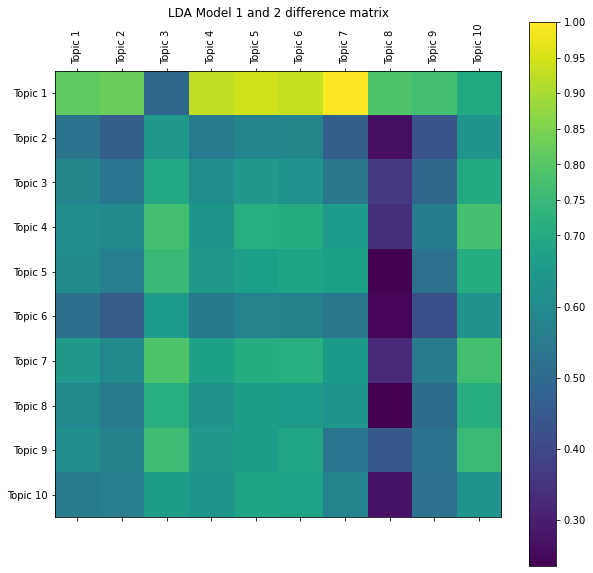

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(mdiff)
plt.title('LDA Model 1 and 2 difference matrix')
plt.xticks(range(10), labels, rotation=90);
plt.yticks(range(10), labels);
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

In [301]:
def plot_model_diff(models, labels, title):
    """
    models: this is an array of gensim models
    labels: an array of topic labels
    """
    
    plot_size = len(models)
    
    fig, axes = plt.subplots(plot_size, plot_size, figsize=(30, 30))
    #axes = axes.flatten()
    
    for model_ind in range(plot_size):
        for model_ind_comp in range(plot_size):
            ax = axes[model_ind][model_ind_comp]
            ax.set_title(f'LDA Model {model_ind+1} and {model_ind_comp+1} Differences', fontdict={'fontsize': 20})

            try:
                # calculate KL divergence matrix and store in mdiff
                mdiff, annotation = models[model_ind].diff(models[model_ind_comp])
                cax = ax.imshow(mdiff)
            except:
                print(f'Comparison Error Between Models {model_ind+1} and {model_ind_comp+1}')
                cax = ax.imshow(np.zeros((len(labels),len(labels))))

            ax.set_xticks(np.arange(len(labels)))
            ax.set_yticks(np.arange(len(labels)))
            ax.set_xticklabels(labels)
            ax.set_yticklabels(labels)            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")

    fig.suptitle(title, fontsize=40) 
    fig.colorbar(cax, ax=axes, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1], shrink=0.6, fraction=0.1)
    plt.show()

In [270]:
model_arr = [lda_model_1, lda_model_2, lda_model_3, lda_model_4]

Comparison Error Between Models 1 and 3
Comparison Error Between Models 1 and 4
Comparison Error Between Models 2 and 3
Comparison Error Between Models 2 and 4
Comparison Error Between Models 3 and 1
Comparison Error Between Models 3 and 2
Comparison Error Between Models 3 and 4
Comparison Error Between Models 4 and 1
Comparison Error Between Models 4 and 2
Comparison Error Between Models 4 and 3


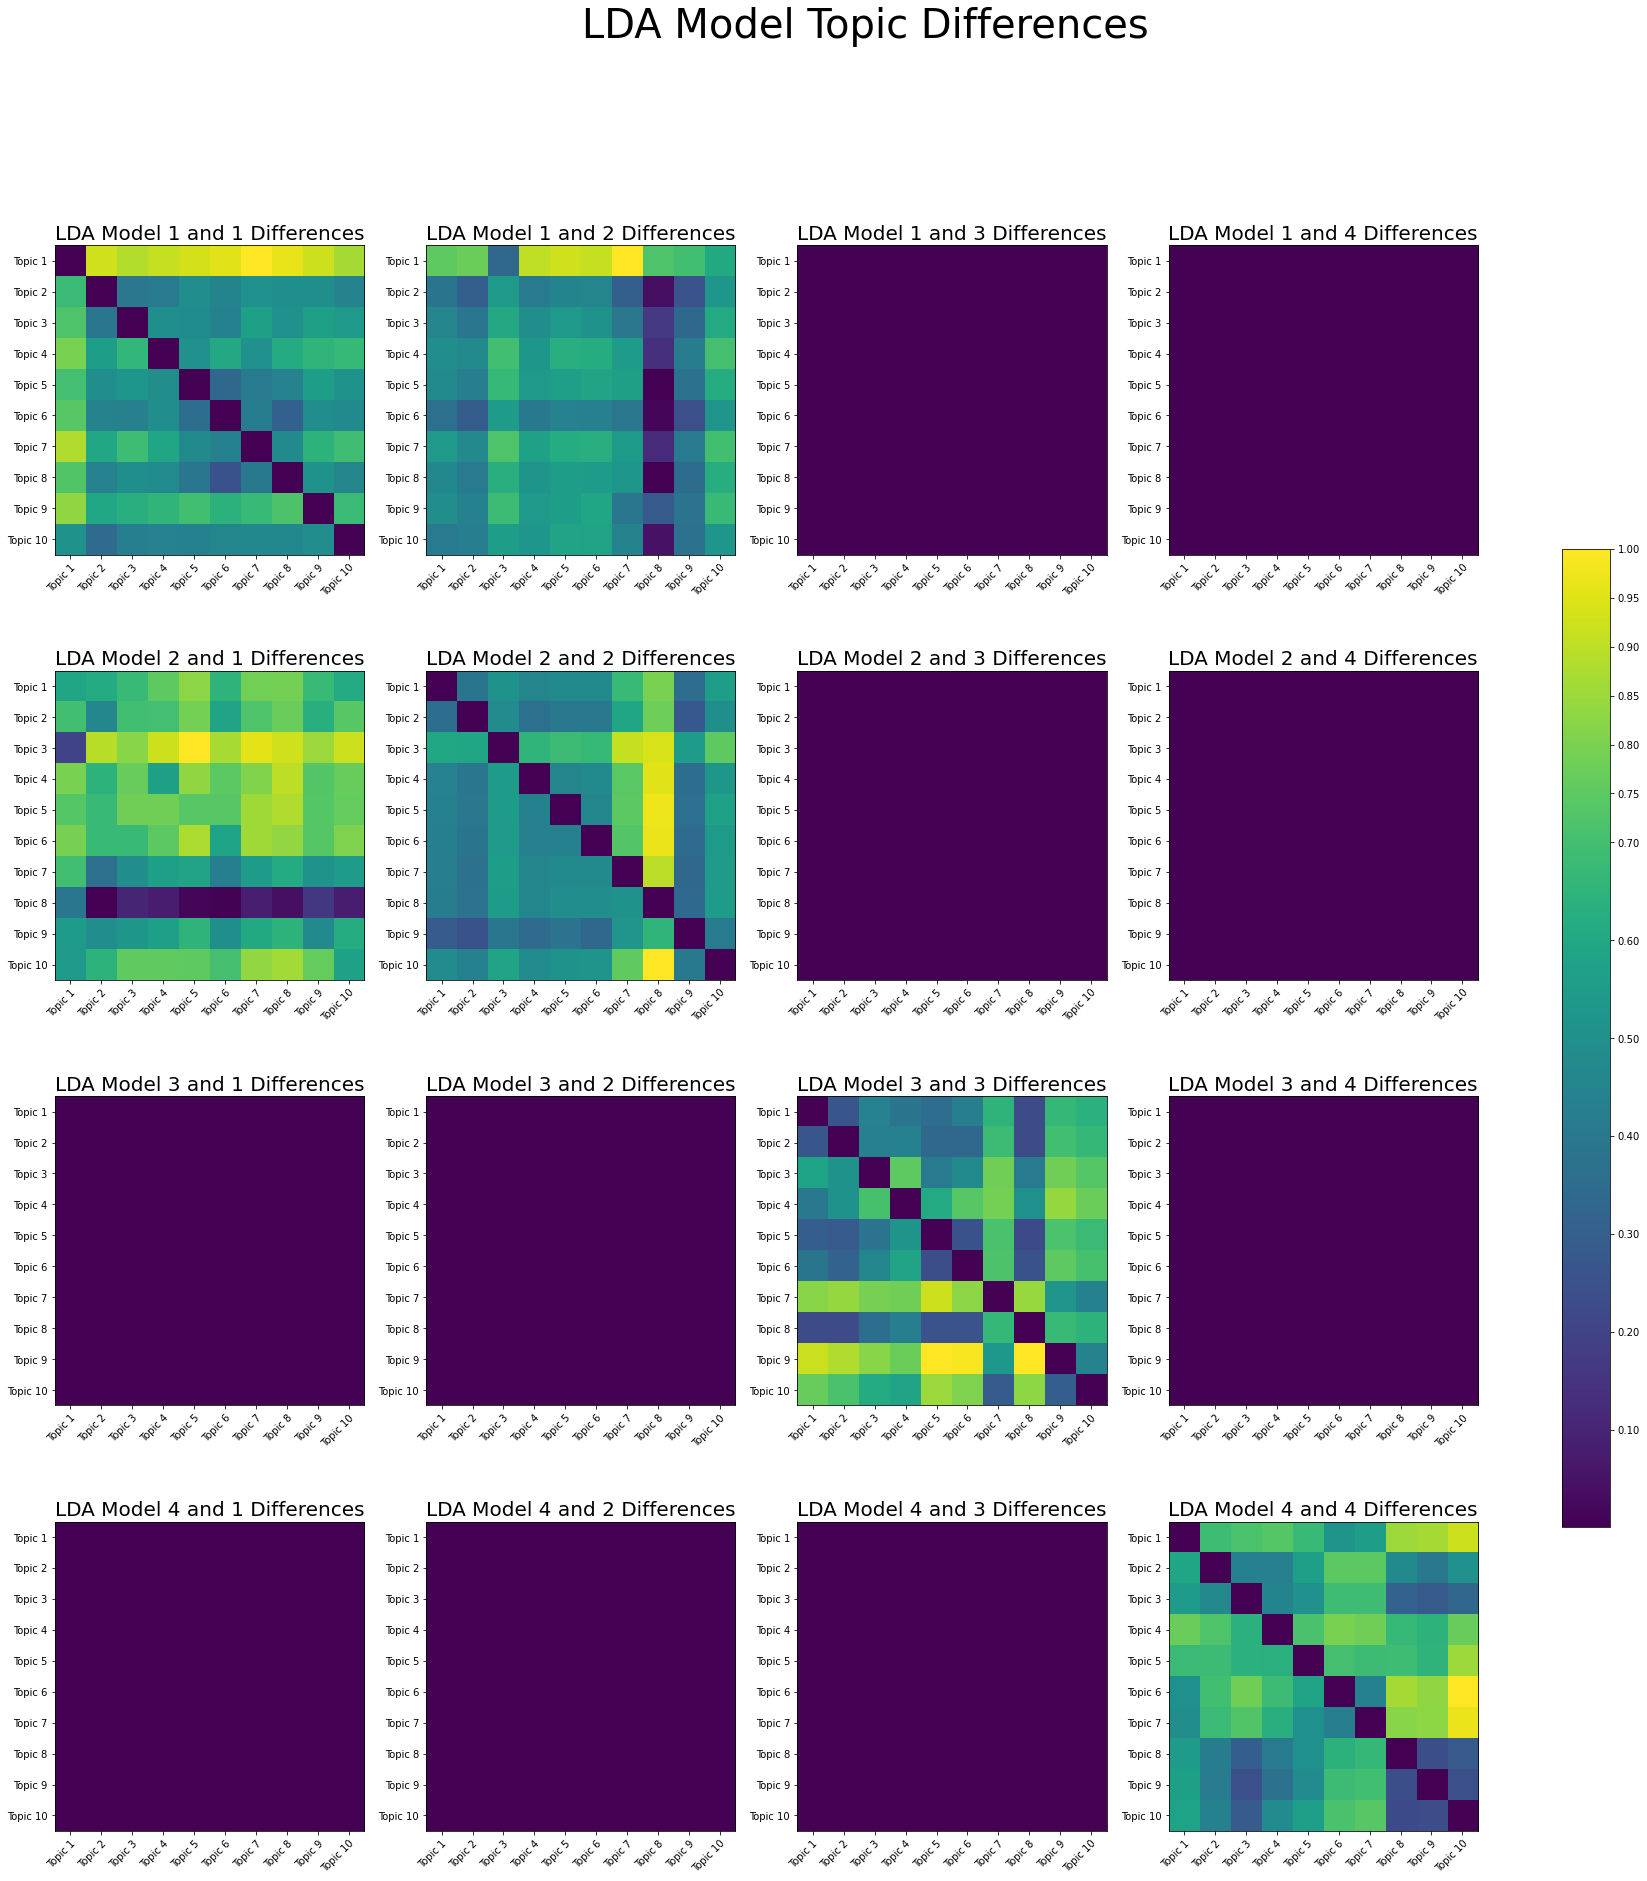

In [302]:
plot_model_diff(model_arr, labels, 'LDA Model Topic Differences')

# Visualizing Document Topics

In [ ]:
lda_model_1